# Use Machine Learning to predict short-term stock price movement

- From the raw Market Tick Data, construct Order Book
- Generates the features dataset from Order Book
- Import the labelled dataset (order book features and the target)
- It contains L1, L2, L3 order_book_imbalance and MF (money_flow) to predict the next stock price movement (u=up or d=down)
- The data is normalized to the range of -1 to 1

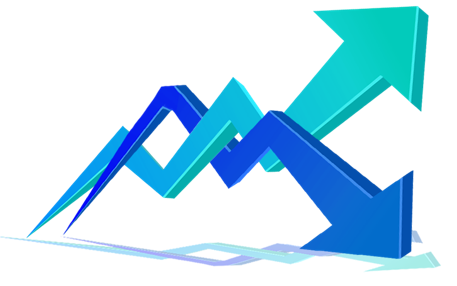

In [ ]:
#@title Execute this block to start importing the libraries (**sklearn** for Machine Learning) and helper functions
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

#scikit learn Machine Learning library
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# interative plotting library
import altair as alt

# Enable Google interactive table
from google.colab import data_table
data_table.enable_dataframe_formatter()

SCREEN_X, SCREEN_Y = 12, 8

In [ ]:
#@title Load the labelled dataset
orderBook = pd.read_csv("https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/20131002-5HK-OrderBookFeatures.csv")
orderBook

In [ ]:
#@title Split dataset in features and target which means using the features to predict the target
feature_cols = ['L1', 'L2', 'L3', 'MF']
X = orderBook[feature_cols] # Features
y = orderBook.Dir # Target variable

print("Features:", X.columns)
print("Target:", y.name)

In [ ]:
#@title Scatter plot all the order book features
sns.pairplot(orderBook, hue="Dir",palette="bright")

In [ ]:
#@title Compare 2 order book features interactively

feature_1 = 'L1' #@param ['L1', 'L2', 'L3', 'MF']
feature_2 = 'L2' #@param ['L1', 'L2', 'L3', 'MF']

alt.Chart(orderBook).mark_point().encode(
  x=feature_1,
  y=feature_2,
  color='Dir'
).properties(
  width=640,
  height=480
).interactive()

In [ ]:
#@title Split dataset into training set (80%) and test set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print("Training feature size:", X_train.shape)
print("Testing feature size:", X_test.shape)

# Decision Tree

- **value**: how many samples in each category (Down vs Up in this case)
- **gini**: quantifies the purity of the node/leaf.
-- A gini score greater than zero implies that samples contained within that node belong to different classes.
-- A gini score of zero means that the node is pure, that within that node only a single class of samples exist.


In [ ]:
#@title Set the treeDepth **hyper-paramter**

# https://www.datacamp.com/community/tutorials/decision-tree-classification-python
from sklearn import tree

# Create Decision Tree classifer object with max_depth
# max_depth is the hyper-paramter that determine model capacity

treeDepth = 1 #@param {type:"integer"}

dtree = tree.DecisionTreeClassifier(max_depth=treeDepth)

# Train Decision Tree Classifer
dtree = dtree.fit(X_train,y_train)

# Visualize the decision tree
dot_data = tree.export_graphviz(dtree, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("imbal")

dot_data = tree.export_graphviz(dtree, out_file=None,
                      feature_names=feature_cols,
                      class_names=["D", "U"],
                      filled=True, rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [ ]:
#@title Measure the Decision tree accuracy
y_dtree_pred_train = dtree.predict(X_train)
y_dtree_pred_test = dtree.predict(X_test)

print("Train Accuracy:", metrics.accuracy_score(y_train, y_dtree_pred_train))
print("Test Accuracy:", metrics.accuracy_score(y_test, y_dtree_pred_test))

# Plot confusion matrix on the train set
cm = confusion_matrix(y_train, y_dtree_pred_train)
ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=dtree.classes_).plot()

In [ ]:
#@title Support Vector Machine

# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
from sklearn.svm import SVC

# use SVM with default settings
svm = SVC()
svm.fit(X_train,y_train)

In [ ]:
#@title Measure the SVM accuracy
y_svm_pred_train = svm.predict(X_train)
y_svm_pred_test = svm.predict(X_test)

print("Train Accuracy:", metrics.accuracy_score(y_train, y_svm_pred_train))
print("Test Accuracy:", metrics.accuracy_score(y_test, y_svm_pred_test))

# Plot confusion matrix on the train set
cm = confusion_matrix(y_train, y_svm_pred_train)
ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=svm.classes_).plot()

# Feature reduction with PCA

In [ ]:
# Scatter plot the L1, L2, L3 order_book_imbalance features
# They have similar patterns and can be compressed

sns.pairplot(orderBook[['L1', 'L2', 'L3', 'Dir']], hue="Dir",palette="bright")

In [ ]:
# If the training time is too long because the input dimension is too high,
# can use PCA to compressed the data features to fewer dimensions
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA

# Compress the L1, L2, L3 order_book_imbalance features into one 'principal component' by PCA
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(orderBook[['L1', 'L2', 'L3']])
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component'])
principalDf

In [ ]:
# Combine back the MF (moneyflow) and the price direction
principalOrderBook = pd.concat([principalDf, orderBook[['MF', 'Dir']]], axis = 1)
principalOrderBook

In [ ]:
# Plot 'principal component' vs 'money flow'
alt.Chart(principalOrderBook).mark_point().encode(x='principal component', y='MF', color='Dir').properties(width=320, height=240).interactive()

In [ ]:
# Plot imbalance vs 'money flow'
alt.Chart(orderBook).mark_point().encode(x='L1', y='MF', color='Dir').properties(width=320, height=240).interactive()

In [ ]:
# split dataset in features and target variable
# which means using the features to predict the target
feature_cols = ['principal component', 'MF']
pX = principalOrderBook[feature_cols] # Features
py = principalOrderBook.Dir # Target variable

print("Features:", pX.columns)
print("Target:", py.name)

# Split dataset into training set and test set
# 80% training and 20% test
pX_train, pX_test, py_train, py_test = train_test_split(pX, py, test_size=0.2, random_state=1)

print("Training feature size:", pX_train.shape)
print("Testing feature size:", pX_test.shape)

In [ ]:
# Train the principle feature by decision tree and measure the performance
pDtree = tree.DecisionTreeClassifier(max_depth=treeDepth).fit(pX_train, py_train)
py_dtree_pred_train = pDtree.predict(pX_train)
py_dtree_pred_test = pDtree.predict(pX_test)

# accuracy with the PCA feature
print("PCA Train Accuracy:", metrics.accuracy_score(py_train, py_dtree_pred_train))
print("PCA Test Accuracy:", metrics.accuracy_score(py_test, py_dtree_pred_test))

# accuracy without the PCA feature
print("Train Accuracy:", metrics.accuracy_score(y_train, y_dtree_pred_train))
print("Test Accuracy:", metrics.accuracy_score(y_test, y_dtree_pred_test))

In [ ]:
# Train the principle feature by SVM and measure the performance
pSvm = SVC().fit(pX_train, py_train)
py_svm_pred_train = pSvm.predict(pX_train)
py_svm_pred_test = pSvm.predict(pX_test)

print("PCA Train Accuracy:", metrics.accuracy_score(py_train, py_svm_pred_train))
print("PCA Test Accuracy:", metrics.accuracy_score(py_test, py_svm_pred_test))

print("Train Accuracy:", metrics.accuracy_score(y_train, y_svm_pred_train))
print("Test Accuracy:", metrics.accuracy_score(y_test, y_svm_pred_test))

# Further hyper-parameter tuning

In [ ]:
# Partitioning the available data into three sets (train, validation, test)
# will drastically reduce the number of samples which can be used for learning the model,
# and the results can depend on a particular random choice for the pair of (train, validation) sets.
# Use cross-validation (CV): a test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV.
# https://scikit-learn.org/stable/modules/cross_validation.html

from sklearn.model_selection import cross_val_score

scores = cross_val_score(dtree, X_train, y_train, cv=5)
print("Decision Tree Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(scores)

scores = cross_val_score(svm, X_train, y_train, cv=5)
print("SVM Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(scores)

In [ ]:
# Hyper-parameters optimization using grid search with cross-validation
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.exceptions import UndefinedMetricWarning

import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()